In [53]:
import pandas as pd
import numpy as np
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns #heat map
from scipy.stats import pearsonr 


In [54]:
Range = 100

In [55]:
L_range = np.linspace(0, 1.5, num=Range)
am_range = np.linspace(1.33, np.pi/2, num=Range)
an_range = np.linspace(0.55*np.pi/2, 0.3*np.pi/2, num=Range)

L_grid, am_grid, an_grid = np.meshgrid(L_range, am_range, an_range)


In [56]:
#Create two functions of dx and dy so we can link and evaluate how they change with different parameters


def dx(L,am,an):
    return 2 * L * np.sin(0.25*(am - an)) * np.cos(0.25*(am + an))

def dy(L,am,an):
    return (-2) * L *np.sin(0.25*(an + am)) * np.sin(0.25*(an - am))



In [57]:
# 4. Create initial DataFrame
df = pd.DataFrame({
    'L': L_grid.ravel(),
    'am': am_grid.ravel(),
    'an': an_grid.ravel() #.ravel() flattens the 3D arrays into 1D arrays for DataFrame creation
})

df['DX']=dx(df['L'],df['am'],df['an'])
df['DY']=dy(df['L'],df['am'],df['an'])
df_filtered = df[df['DX'] > 0.24999].copy()

# Count the original total (64^3 = 262,144)
total_rows = len(df)

# Count the rows that passed the filter (DX > 0.250)
valid_rows = len(df_filtered)

# The difference is the count of rows below or equal to 0.249
rows_below_250 = total_rows - valid_rows

print(f"Total combinations: {total_rows}")
print(f"Rows > 0.250: {valid_rows}")
print(f"Rows <= 0.250 (Excluded): {rows_below_250}")

Total combinations: 1000000
Rows > 0.250: 486665
Rows <= 0.250 (Excluded): 513335


In [58]:
# See the first 5 rows
print(df_filtered.head())

# See the first 20 rows
print(df_filtered.head(20))

# See the last 5 rows
print(df_filtered.tail())

             L    am        an        DX        DY
4495  0.666667  1.33  0.487106  0.250605  0.122380
4496  0.666667  1.33  0.483139  0.251888  0.122698
4497  0.666667  1.33  0.479172  0.253172  0.123013
4498  0.666667  1.33  0.475206  0.254457  0.123325
4499  0.666667  1.33  0.471239  0.255743  0.123635
             L    am        an        DX        DY
4495  0.666667  1.33  0.487106  0.250605  0.122380
4496  0.666667  1.33  0.483139  0.251888  0.122698
4497  0.666667  1.33  0.479172  0.253172  0.123013
4498  0.666667  1.33  0.475206  0.254457  0.123325
4499  0.666667  1.33  0.471239  0.255743  0.123635
4591  0.681818  1.33  0.502972  0.251056  0.123837
4592  0.681818  1.33  0.499005  0.252366  0.124172
4593  0.681818  1.33  0.495039  0.253677  0.124504
4594  0.681818  1.33  0.491072  0.254988  0.124834
4595  0.681818  1.33  0.487106  0.256300  0.125162
4596  0.681818  1.33  0.483139  0.257613  0.125487
4597  0.681818  1.33  0.479172  0.258926  0.125809
4598  0.681818  1.33  0.475206 

In [59]:

maov = MANOVA.from_formula('DX + DY ~ L + am + an', data=df_filtered)
mv_test=maov.mv_test()

print(maov.mv_test())

                       Multivariate linear model
                                                                       
-----------------------------------------------------------------------
        Intercept         Value  Num DF    Den DF     F Value    Pr > F
-----------------------------------------------------------------------
           Wilks' lambda  0.0560 2.0000 486660.0000 4099320.7703 0.0000
          Pillai's trace  0.9440 2.0000 486660.0000 4099320.7703 0.0000
  Hotelling-Lawley trace 16.8468 2.0000 486660.0000 4099320.7703 0.0000
     Roy's greatest root 16.8468 2.0000 486660.0000 4099320.7703 0.0000
-----------------------------------------------------------------------
                                                                       
-----------------------------------------------------------------------
           L             Value  Num DF    Den DF      F Value    Pr > F
-----------------------------------------------------------------------
          Wilks

In [60]:
#sensitivity DX

def sensitivity(inputs, output):
    S = []
    for i in range(inputs.shape[1]):
        r, _ = pearsonr(inputs[:,i], output)
        S.append(abs(r))
    S = np.array(S)
    return S / S.sum()

inputs = df_filtered[['L', 'am', 'an']].values
output_dx = df_filtered['DX'].values

# Run your sensitivity function
s_indices = sensitivity(inputs, output_dx)

# Create a clean summary
sensitivity_df = pd.DataFrame({
    'Variable': ['L', 'am', 'an'],
    'Sensitivity_Index': s_indices
})

print(sensitivity_df)

  Variable  Sensitivity_Index
0        L           0.540322
1       am           0.144615
2       an           0.315063


In [61]:
#sensitivity DY

def sensitivity(inputs, output):
    S = []
    for i in range(inputs.shape[1]):
        r, _ = pearsonr(inputs[:,i], output)
        S.append(abs(r))
    S = np.array(S)
    return S / S.sum()

inputs = df_filtered[['L', 'am', 'an']].values
output_dy = df['DY'].values

# Run your sensitivity function
s_indices = sensitivity(inputs, output_dx)

# Create a clean summary
sensitivity_df = pd.DataFrame({
    'Variable': ['L', 'am', 'an'],
    'Sensitivity_Index': s_indices
})

print(sensitivity_df)

  Variable  Sensitivity_Index
0        L           0.540322
1       am           0.144615
2       an           0.315063


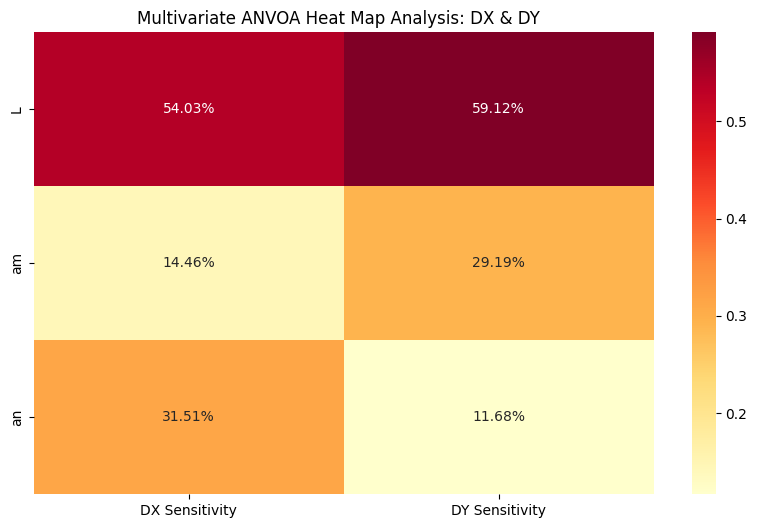

In [62]:

# 1. Define inputs for the filtered data
ivs = ['L', 'am', 'an']
X_data = df_filtered[ivs].values

# 2. Run your sensitivity function for both targets
sens_dx = sensitivity(X_data, df_filtered['DX'].values)
sens_dy = sensitivity(X_data, df_filtered['DY'].values)

# 3. Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'DX Sensitivity': sens_dx,
    'DY Sensitivity': sens_dy
}, index=ivs)

# 4. Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(comparison_df, annot=True, fmt=".2%", cmap='YlOrRd')
plt.title('Multivariate ANVOA Heat Map Analysis: DX & DY  ')
plt.show()

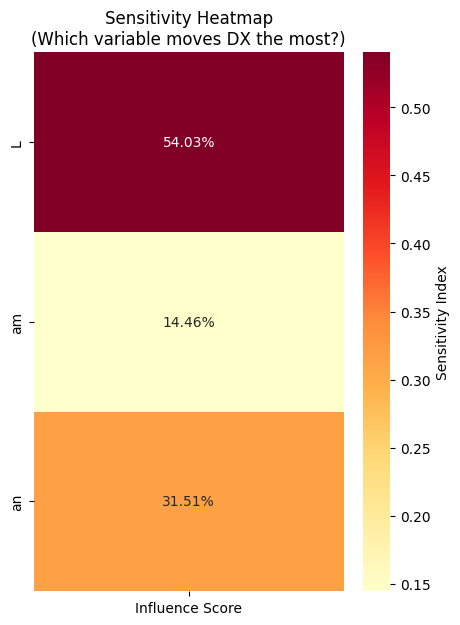

In [63]:
#Heat Map DX

inputs = df_filtered[['L', 'am', 'an']].values
output_dx = df_filtered['DX'].values
s_indices = sensitivity(inputs, output_dx)

# 2. Format the data for a Heatmap
# We create a 1-column DataFrame where the rows are L, am, and an
sensitivity_results = pd.DataFrame(s_indices, index=['L', 'am', 'an'], columns=['Influence Score'])

# 3. Create the Heat Graph
plt.figure(figsize=(5, 7))
sns.heatmap(sensitivity_results, annot=True, fmt=".2%", cmap="YlOrRd", cbar_kws={'label': 'Sensitivity Index'})

plt.title('Sensitivity Heatmap\n(Which variable moves DX the most?)')
plt.show()

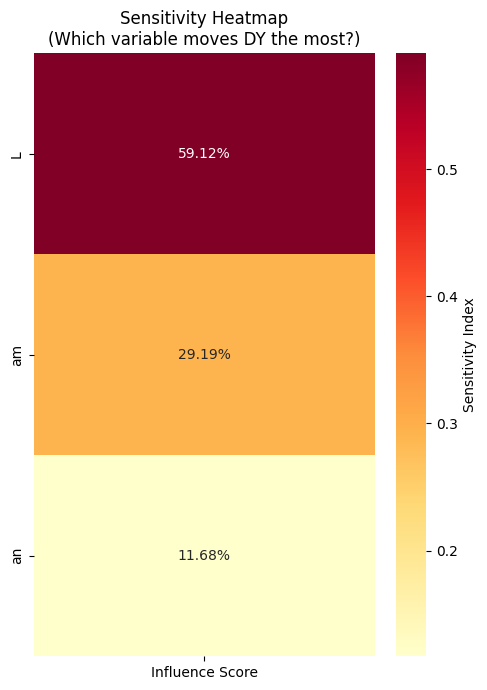

In [64]:
# Heat Map DY (fixed)
inputs = df_filtered[['L', 'am', 'an']].values
output_dy = df_filtered['DY'].values            # use filtered values (same length as inputs)
s_indices = sensitivity(inputs, output_dy)      # compute sensitivity for DY

sensitivity_results = pd.DataFrame(s_indices, index=['L', 'am', 'an'], columns=['Influence Score'])

plt.figure(figsize=(5, 7))
sns.heatmap(sensitivity_results, annot=True, fmt=".2%", cmap="YlOrRd", cbar_kws={'label': 'Sensitivity Index'})
plt.title('Sensitivity Heatmap\n(Which variable moves DY the most?)')
plt.tight_layout()
plt.show()